In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
from pathlib import Path
import numpy as np
import os
from matplotlib import pyplot as plt
import matplotlib as mpl
from time import time

%matplotlib inline
np.seterr(all='warn')
textwidth = 6.268
mpl.rcParams['figure.dpi'] = 70
default_figargs = dict(figsize = (textwidth,textwidth))

import logging
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING) 

from import_funcs import get_data
from FKMC.general import shapes

In [14]:
from time import time
from operator import mul
from functools import reduce
def product(iterable): return reduce(mul, iterable)
from munch import Munch
from itertools import count
from matplotlib import colors

from FKMC.general import index_histogram_array, sort_IPRs, smooth
from import_funcs import get_data_structured

In [15]:
%%time
obs = get_data_structured(Path('/data/users/tch14/slurm_runs/96040'),
                requested_observables = ['Ff', 'Fc', 'Mf_moments', 'time', 'IPRs', 'eigenvals', 'state','accept_rates', 'classical_accept_rates', 'proposal_rates'],
                MCMC_slice = slice(None,None,None),
                structure_names = ('Ts',),
               )

looking in /data/users/tch14/slurm_runs/96040
job ids range from 0 to 99
structure_names = ('Ts',)
structure_dims = (100,)
Expected number of jobs 100
Missing jobs: set()

Logger keys:  ['Ns', 'Ts', 'parameters', 'MCMC_params', 'logs', 'desc'] 

MCMC_params:  {'state': '...', 'N_steps': 100000, 'N_burn_in': 10000, 'thin': 100, 'logger': <FKMC.montecarlo.Eigenspectrum_IPR_all object at 0x7f75ea20edd8>, 'proposal': <function p_multi_site_uniform_reflect at 0x7f7637344c80>, 'accept_function': <function perturbation_accept at 0x7f7637343048>, 'warnings': True} 

MCMC Steps: 100000 with thinning = 100 for 1000 recorded steps
Slicing this with MCMC_slice = slice(None, None, None)

[(0, 'Ts', 100)]
available observables = ['A', 'Fc', 'Ff', 'IPRs', 'Mf_moments', 'N_cumulants', 'N_sites', 'N_steps', 'Nc', 'Nf', 'accept_rates', 'classical_accept_rates', 'eigenval_bins', 'eigenvals', 'last_state', 'powers', 'proposal_rates', 'return_vals', 'start', 'state', 'time', 'update']
requested observables

In [16]:
obs2 = get_data_structured(Path('/data/users/tch14/slurm_runs/96843'),
                requested_observables = ['Ff', 'Fc', 'Mf_moments', 'time', 'IPRs', 'eigenvals', 'state'],
                MCMC_slice = slice(None,None,None),
                structure_names = ('Ts',)
               )

looking in /data/users/tch14/slurm_runs/96843
job ids range from 0 to 99
structure_names = ('Ts',)
structure_dims = (100,)
Expected number of jobs 100
Missing jobs: {43}

Logger keys:  ['Ns', 'Ts', 'parameters', 'MCMC_params', 'logs', 'desc'] 

MCMC_params:  {'state': '...', 'N_steps': 1000000, 'N_burn_in': 10000, 'thin': 1000, 'logger': <FKMC.montecarlo.Eigenspectrum_IPR_all object at 0x7f75ea20e320>, 'proposal': <function p_multi_site_uniform_reflect at 0x7f7637344c80>, 'accept_function': <function perturbation_accept at 0x7f7637343048>, 'warnings': True} 

MCMC Steps: 1000000 with thinning = 1000 for 1000 recorded steps
Slicing this with MCMC_slice = slice(None, None, None)

[(0, 'Ts', 100)]
available observables = ['A', 'Fc', 'Ff', 'IPRs', 'Mf_moments', 'N_cumulants', 'N_sites', 'N_steps', 'Nc', 'Nf', 'accept_rates', 'classical_accept_rates', 'eigenval_bins', 'eigenvals', 'last_state', 'powers', 'proposal_rates', 'return_vals', 'start', 'state', 'time', 'update']
requested observab

## Quck distribution of all the eigenvals of N = 128 to get a sense of the boundaries

(array([1324237., 2681412., 1101300., 1171862.,  121332.,  120774.,
        1172316., 1092946., 2689073., 1324748.]),
 array([-4.47842977e+00, -3.58296327e+00, -2.68749676e+00, -1.79203026e+00,
        -8.96563764e-01, -1.09726407e-03,  8.94369236e-01,  1.78983574e+00,
         2.68530224e+00,  3.58076874e+00,  4.47623524e+00]),
 <a list of 10 Patch objects>)

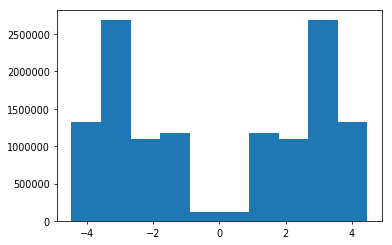

In [6]:
plt.hist(obs.eigenvals[-1].flatten())

## Eigenvals have shape (Temp vals, mcmc steps, system size)

In [7]:
obs.eigenvals[-1].shape

(100, 1000, 128)

## Plots: Order parameter, binder cumulant, zoom on binder cumulant

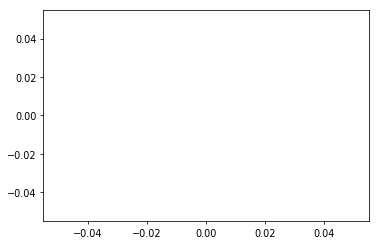

In [10]:
i = 0

p_propose = obs.proposal_rates[i] / obs.proposal_rates[i].sum(axis=-1, keepdims = True)
p_classical_accept = obs.classical_accept_rates[i] / obs.classical_accept_rates[i].sum(axis=-1, keepdims = True) / p_propose
p_accept = obs.accept_rates[i] / obs.accept_rates[i].sum(axis=-1,keepdims = True) / p_propose

#plt.pcolormesh(obs.T, range(6), obs.accept_rates[i].T / obs.proposal_rates[i].T)
plt.scatter(obs.Ts, obs.accept_rates[i].sum(-1) / obs.proposal_rates[i].sum(-1))

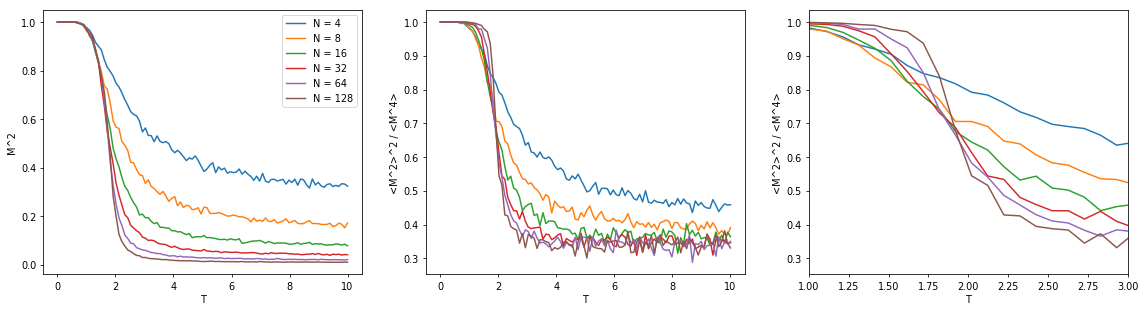

In [18]:
f, (ax0, ax1, ax2) = plt.subplots(1,3, figsize = (20,5))

for N, M2 in zip(obs.Ns, obs.Mf_moments[:, :, 2, :].mean(axis=-1)):
    ax0.plot(obs.Ts, M2, label = f'N = {N}')
    
ax0.set(ylabel = 'M^2', xlabel = 'T');
ax0.legend()

M2 = obs.Mf_moments[:, :, 2, :].mean(axis=-1).T
M4 = obs.Mf_moments[:, :, 4, :].mean(axis=-1).T

ax1.plot(obs.Ts, M2**2 / M4);
ax1.set(ylabel = '<M^2>^2 / <M^4>', xlabel = 'T');

ax2.plot(obs.Ts, M2**2 / M4);
ax2.set(ylabel = '<M^2>^2 / <M^4>', xlabel = 'T', xlim = (1,3) );

f = '/home/tch14/workspace/fake_home/Dropbox/Apps/Overleaf/Short Paper/figs/binder.npz'
np.savez(f, T = obs.Ts, B = M2**2 / M4)

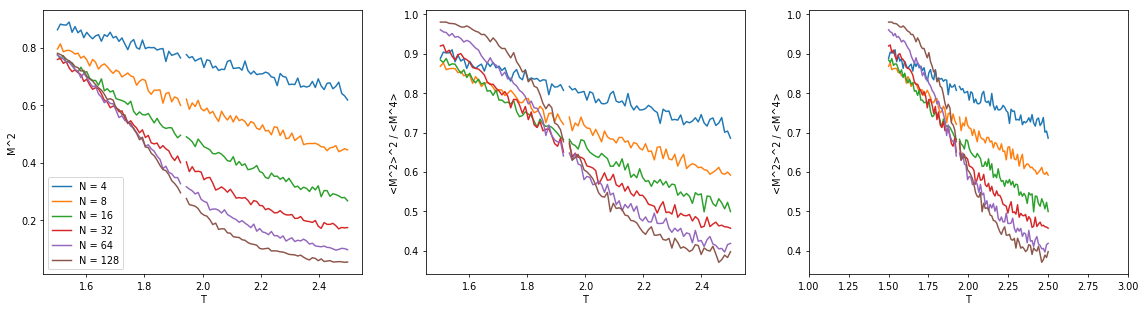

In [19]:
f, (ax0, ax1, ax2) = plt.subplots(1,3, figsize = (20,5))

for N, M2 in zip(obs2.Ns, obs2.Mf_moments[:, :, 2, :].mean(axis=-1)):
    ax0.plot(obs2.Ts, M2, label = f'N = {N}')
    
ax0.set(ylabel = 'M^2', xlabel = 'T');
ax0.legend()

M2 = obs2.Mf_moments[:, :, 2, :].mean(axis=-1).T
M4 = obs2.Mf_moments[:, :, 4, :].mean(axis=-1).T

ax1.plot(obs2.Ts, M2**2 / M4);
ax1.set(ylabel = '<M^2>^2 / <M^4>', xlabel = 'T');

ax2.plot(obs2.Ts, M2**2 / M4);
ax2.set(ylabel = '<M^2>^2 / <M^4>', xlabel = 'T', xlim = (1,3) );

## Plots of spectrum and IPR for different system sizes 

/home/tch14/conda-envs/intelpython3.5/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


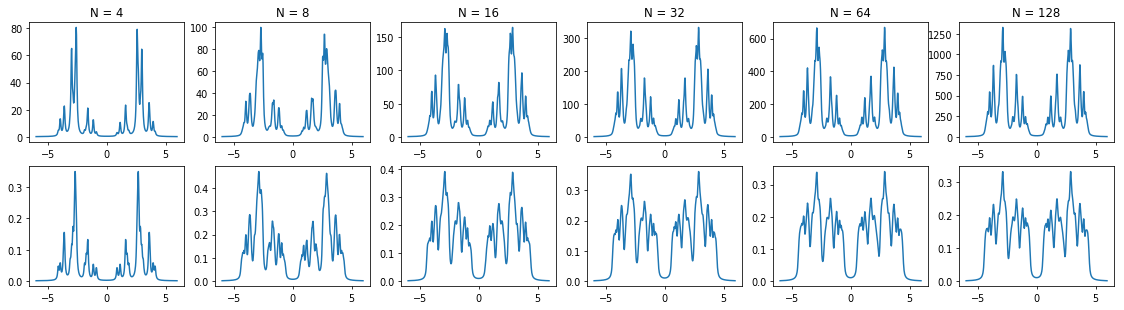

In [20]:
from itertools import count

from FKMC.general import index_histogram

T_index = 30
f, axes = plt.subplots(2,6, figsize = (20,5))

for i, ax, N in zip(count(), axes.T, obs.Ns):
    E_bins = np.linspace(-6, 6, 500 + 1)
    E_hist, _, indices = index_histogram(E_bins, obs.eigenvals[i][T_index].flatten())
    IPR_hist = np.bincount(indices, weights = obs.IPRs[i][T_index].flatten(), minlength = E_bins.shape[0] + 1)[1:-1]

    I = np.where(E_hist > 0, IPR_hist / E_hist, 0)
    
    ax[0].plot(E_bins[:-1], smooth(E_hist, scale = 1))
    ax[1].plot(E_bins[:-1], smooth(I, scale = 1))
    
    ax[0].set(title = f'N = {N}')

## Plots of spectrum and IPR for different temperaures N = 128

/home/tch14/conda-envs/intelpython3.5/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


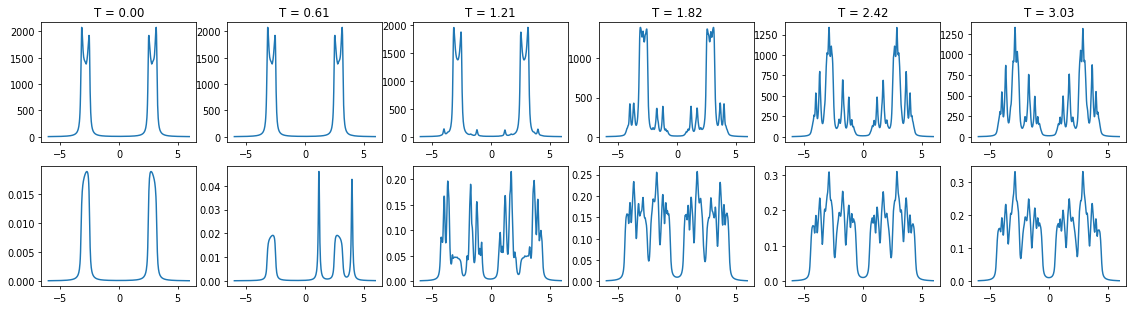

In [21]:
from FKMC.general import index_histogram

T_is = np.linspace(0, 30, 6, dtype = np.int)
f, axes = plt.subplots(2,6, figsize = (20,5))

for i, ax, N, T_i in zip(count(), axes.T, obs.Ns, T_is):
    E_bins = np.linspace(-6, 6, 500 + 1)
    E_hist, _, indices = index_histogram(E_bins, obs.eigenvals[-1][T_i].flatten())
    IPR_hist = np.bincount(indices, weights = obs.IPRs[-1][T_i].flatten(), minlength = E_bins.shape[0] + 1)[1:-1]
    
    I = np.where(E_hist > 0, IPR_hist / E_hist, 0)
    
    ax[0].plot(E_bins[:-1], smooth(E_hist, scale = 1))
    ax[1].plot(E_bins[:-1], smooth(I, scale = 1))
    
    ax[0].set(title = f'T = {obs.Ts[T_i]:.2f}')

## Testing a vectorised version of the same code

/home/tch14/conda-envs/intelpython3.5/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


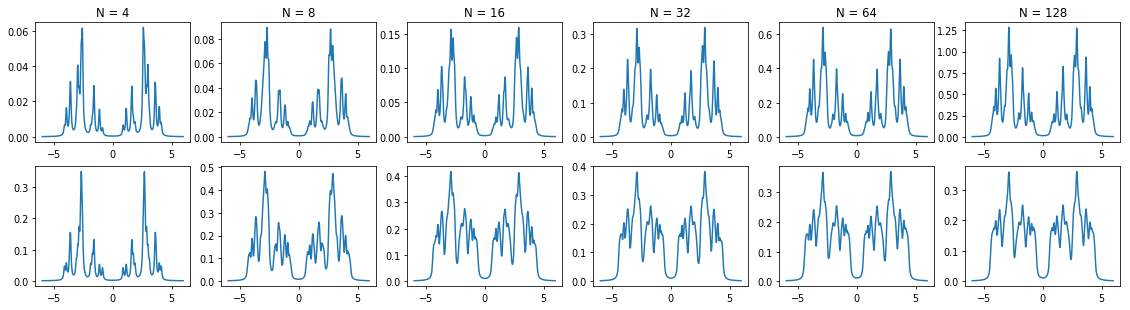

In [22]:
f, axes = plt.subplots(2,6, figsize = (20,5))

for i, ax, N in zip(count(), axes.T, obs.Ns):
    T_index = 50

    E_vals = obs.eigenvals[i]
    IPRs = obs.IPRs[i]

    E_bins = np.linspace(-6, 6, 500 + 1)
    E_hist, _, indices = index_histogram_array(E_bins, E_vals)
    IPR_hist = sort_IPRs(indices, IPRs, E_bins)

    E = E_hist[T_index].mean(axis=0)
    I = np.where(E > 0, IPR_hist[T_index].mean(axis=0) / E, 0)
    
    ax[0].plot(E_bins[:-1], smooth(E, scale = 1))
    ax[1].plot(E_bins[:-1], smooth(I, scale = 1))
    
    ax[0].set(title = f'N = {N}')

/home/tch14/conda-envs/intelpython3.5/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/home/tch14/conda-envs/intelpython3.5/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


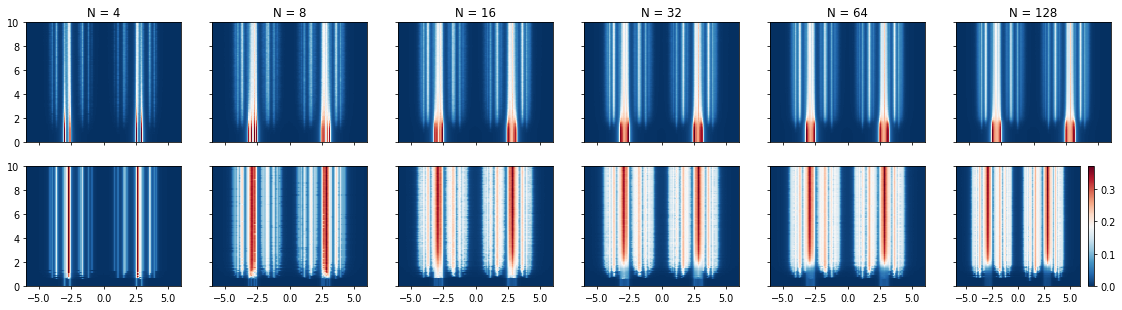

In [23]:
f, axes = plt.subplots(2,6, figsize = (20,5), sharex = 'all', sharey = 'all')

for i, ax, N in zip(count(), axes.T, obs.Ns):
    
    E_vals = obs.eigenvals[i]
    IPRs = obs.IPRs[i]
    
    newshape = E_vals.shape[:-2] + (-1,)
    IPRs = IPRs.reshape(*newshape)
    E_vals = E_vals.reshape(*newshape)
    
    E_bins = np.linspace(-6, 6, 500 + 1)
    E_hist, _, indices = index_histogram_array(E_bins, E_vals)
    IPR_hist = sort_IPRs(indices, IPRs, E_bins)

    I = np.where(E_hist > 0, IPR_hist/E_hist, 0)
    sI = smooth(I, scale = 1, axis = -1)
    sE = smooth(E_hist, scale = 1, axis = -1)
    
    norm = colors.Normalize(vmin = 0)
    cs = ax[0].pcolormesh(E_bins, obs.Ts, sE, cmap='RdBu_r', norm = norm)
    
    norm = colors.Normalize(vmin = 0)
    cs = ax[1].pcolormesh(E_bins, obs.Ts, sI, cmap='RdBu_r', norm = norm)
    
    ax[0].set(title = f'N = {N}', ylim = (0, 10))

    
    
f.colorbar(cs)

## Plot the correlations functions at different temperatures

In [24]:
obs.state[-1].shape

(100, 1000, 128)

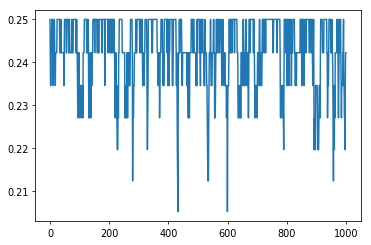

In [25]:
states = obs.state[-1]
N = states.shape[-1]
alternating = 2*(np.arange(N) % 2) - 1
a_states = states * alternating

plt.plot(a_states.mean(axis = -1)[10]**2)

AttributeError: 'numpy.ndarray' object has no attribute 'set'

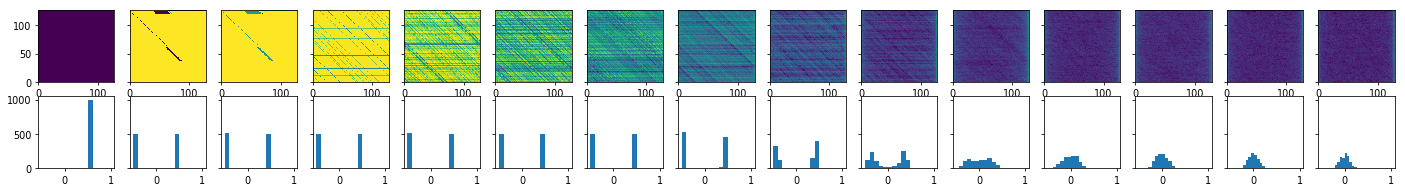

In [26]:
from FKMC.general import spread, diag2column

T_slice = slice(None, 30, 2)
Ts = obs.Ts[T_slice]
N_axes = len(Ts)
indices = np.arange(obs.Ts.shape[-1])[T_slice]

f, axes = plt.subplots(2,N_axes, figsize = (25,3), sharex = 'row', sharey = 'row')

for i,T,(axcorr, axhist) in zip(indices, Ts, axes.T):
    
    #shaps is system size, temp, mcmc step, spatial variable
    states = obs.state[-1][i]
    
    #multiple by (-1)**i
    N = states.shape[-1]
    alternating = 2*(np.arange(N) % 2) - 1
    a_states = states.reshape(-1, N) * alternating
    
    flip = 2*(a_states.mean(axis = -1) > 0) - 1
    #a_states = a_states * flip[:, None]

    #calculate the 2d correlation matrix
    C = np.cov(a_states, rowvar = False)

    axcorr.pcolormesh(diag2column(C.T))
    
    axhist.hist(a_states.mean(axis = -1))
    
    

ax.set(xscale = 'linear', yscale = 'log')
#ax.legend()

AttributeError: module 'matplotlib.colors' has no attribute 'DivergingNorm'

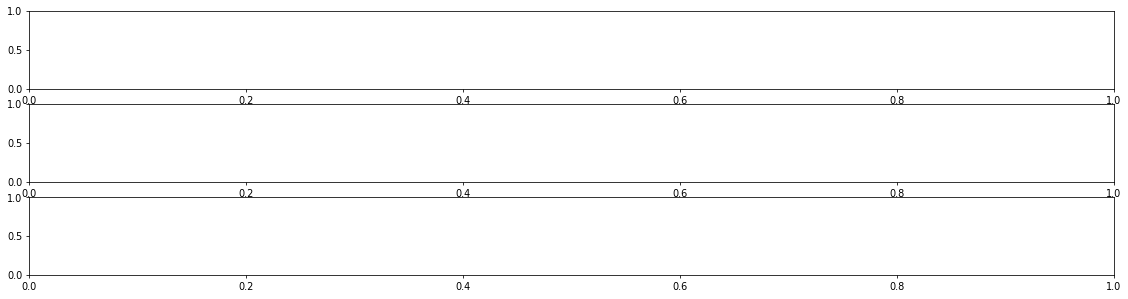

In [27]:
from FKMC.general import spread, diag2column

T_slice = slice(5, None, 5)

f, (axT, ax,ax2) = plt.subplots(3, figsize = (20,5))

coolwarm = plt.get_cmap('coolwarm')
divnorm = colors.DivergingNorm(vmin=0, vcenter=1.7, vmax=10)
def cmap(x): 
    if x < 1.7: return coolwarm(0.5*x/1.7)
    return (x-1.7)


M2 = obs.Mf_moments[-1, :, 2, :].mean(axis=-1)
for i, T, M in zip(count(), obs.Ts, M2):
    axT.scatter([T,] ,[M,], color = cmap(i/obs.Ts.shape[-1]) )

for i,T in zip(np.arange(obs.Ts.shape[-1])[T_slice], obs.Ts[T_slice]):
    
    #shaps is system size, temp, mcmc step, spatial variable
    states = obs.state[-1][i]
    spins = 2*states - 1
    
    #multiple by (-1)**i
    N = states.shape[-1]
    alternating = 2*(np.arange(N) % 2) - 1
    a_states = spins.reshape(-1, N) * alternating
    
    ax2.plot(a_states.mean(0), color = cmap(i/obs.Ts.shape[-1]))

    #calculate the 2d correlation matrix
    C = np.cov(a_states, rowvar = False)

    #calculate the 1d correlation function
    corr_func = diag2column(C).mean(axis = 0)
    dcorr_func = diag2column(C).std(axis = 0)
    
    x = np.arange(N)
    y = np.where(corr_func < 1e-5, np.nan, corr_func)
    ax.plot(x, y, label = f'T = {T}', color = cmap(i/obs.Ts.shape[-1]))
    #spread(ax, x, corr_func, dcorr_func)

ax.set(xscale = 'log', yscale = 'log')
#ax.legend()

# Looking at the acceptance rate as a function of temperature

# Looking at the plot at U = 1 instead of U = 5

In [36]:
"""
%%time
fpath = Path('/data/users/tch14/slurm_runs/98694')
from import_funcs import get_data_structured
obs_U1 = get_data_structured(fpath,
                requested_observables = ['Fc', 'Ff', 'IPRs', 'Mf_moments', 'Nc', 'Nf', 'accept_rates', 'classical_accept_rates', 'eigenval_bins', 'eigenvals', 'last_state', 'proposal_rates', 'state', 'time'],
                structure_names = ('Ts', 'Repeats'),
                structure_dims = (None, 10),
                MCMC_slice = slice(None, None, 10)
               )
import pickle 
fpath = Path('/data/users/tch14/slurm_runs/98694')
with open(fpath/'data.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(obs_U1, f, pickle.HIGHEST_PROTOCOL)  
"""

"\n%%time\nfpath = Path('/data/users/tch14/slurm_runs/98694')\nfrom import_funcs import get_data_structured\nobs_U1 = get_data_structured(fpath,\n                requested_observables = ['Fc', 'Ff', 'IPRs', 'Mf_moments', 'Nc', 'Nf', 'accept_rates', 'classical_accept_rates', 'eigenval_bins', 'eigenvals', 'last_state', 'proposal_rates', 'state', 'time'],\n                structure_names = ('Ts', 'Repeats'),\n                structure_dims = (None, 10),\n                MCMC_slice = slice(None, None, 10)\n               )\nimport pickle \nfpath = Path('/data/users/tch14/slurm_runs/98694')\nwith open(fpath/'data.pickle', 'wb') as f:\n    # Pickle the 'data' dictionary using the highest protocol available.\n    pickle.dump(obs_U1, f, pickle.HIGHEST_PROTOCOL)  \n"

In [35]:
import pickle 
fpath = Path('/data/users/tch14/slurm_runs/98694')
with open(fpath/'data.pickle', 'rb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    obs1_U1 = pickle.load(f)

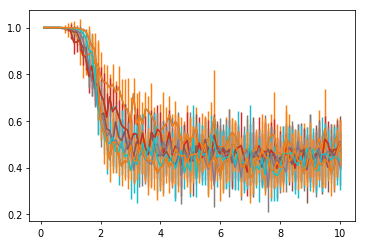

In [37]:
mf = obs_U1.Mf_moments
t = obs_U1.Ts
j = 10

for i in range(6):
    m2s = mf[i, :, :, 2, :j].mean(axis = (-1))
    m4s = mf[i, :, :, 4, :j].mean(axis = (-1))
    B = (m2s**2 / m4s).mean(axis = -1)
    dB = (m2s**2 / m4s).std(axis = -1)
    
    m2s = mf[i, :, :, 2, :].mean(axis = (-1,-2))
    dm2s = mf[i, :, :, 2, :].std(axis = (-1,-2))
    plt.plot(t, B)
    plt.errorbar(t, B, dB)

/home/tch14/conda-envs/intelpython3.5/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/home/tch14/conda-envs/intelpython3.5/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


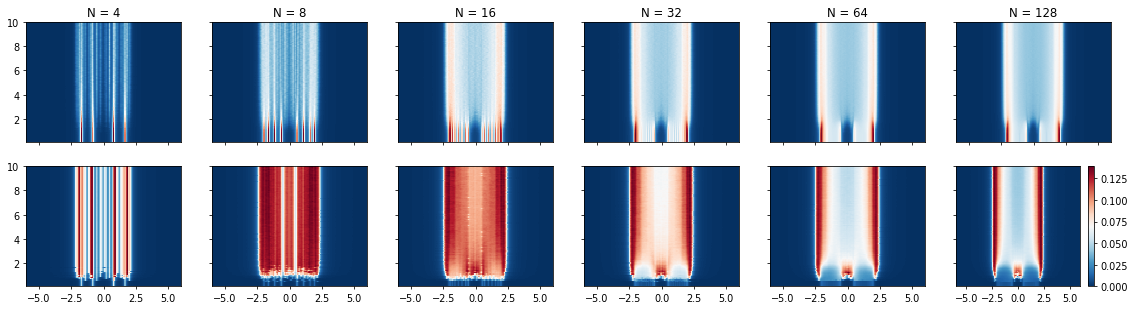

In [39]:
f, axes = plt.subplots(2,6, figsize = (20,5), sharex = 'all', sharey = 'all')

o = obs_U1

for i, ax, N in zip(count(), axes.T, o.Ns):
    
    E_vals = o.eigenvals[i]
    IPRs = o.IPRs[i]
    
    newshape = E_vals.shape[0:1] + (-1,)
    IPRs = IPRs.reshape(*newshape)
    E_vals = E_vals.reshape(*newshape)
    
    E_bins = np.linspace(-6, 6, 500 + 1)
    E_hist, _, indices = index_histogram_array(E_bins, E_vals)
    IPR_hist = sort_IPRs(indices, IPRs, E_bins)

    I = np.where(E_hist > 0, IPR_hist/E_hist, 0)
    sI = smooth(I, scale = 1, axis = -1)
    sE = smooth(E_hist, scale = 1, axis = -1)
    
    norm = colors.Normalize(vmin = 0)
    cs = ax[0].pcolormesh(E_bins, o.Ts, sE, cmap='RdBu_r', norm = norm)
    
    norm = colors.Normalize(vmin = 0)
    cs = ax[1].pcolormesh(E_bins, o.Ts, sI, cmap='RdBu_r', norm = norm)
    
    ax[0].set(title = f'N = {N}')
    
    #save for plotting elsewhere
    if N == 128:
        data = dict(
            command = 'sI = smooth(I, scale = 1, axis = -1); cs = ax[0].pcolormesh(E_bins, o.Ts, sE, cmap="RdBu_r", norm = norm)',
            N = N,
            E = E_hist,
            I = I,
            E_bins = E_bins,
            T = o.Ts,
        )
        file = '/home/tch14/workspace/fake_home/Dropbox/Apps/Overleaf/Short Paper/figs/gap_opening.npz'
        np.savez(file, **data)

    
    
f.colorbar(cs)